In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# SIR

$ \frac{dS}{dt} = - \beta \frac{SI}{N} \\
 \frac{dI}{dt} = \beta \frac{SI}{N} - \mu I \\
 \frac{dR}{dt} = \mu I $

# Gillespie Algorithm

The Gillespie Direct Method Algorithm is an exact algorithm which can produce stochastic simulations for our model. It is a Poison Process that is only dependent on the current state of the system.

In [4]:
def gillespieSIR(initial, beta, mu, max_time):
    T = []
    pop = []
    N = sum(initial)
    pop.append(initial)
    T.append(0)
    t = 0
    ind = 0
    while t <max_time:
        state = np.zeros(shape= (3,2))
        R1 = beta*(pop[ind][0])*(pop[ind][1])/N
        state[:,0] = [-1, 1, 0]
        R2 = mu*(pop[ind][1])
        state[:,1] = [0, -1, 1]
        rate = [R1, R2]
        Rtotal = R1+R2
        delta_t= -np.log(np.random.uniform(0,1))/Rtotal

        P = np.random.uniform(0,1)*Rtotal
        t =t+ delta_t
        event = np.min(np.where(P<=np.cumsum(rate)))
        T.append(t)
        pop.append(pop[ind]+state[:,event])

        ind=ind+1
    return T, np.array(pop)

In [5]:
β = 0.1
μ = 0.01
σ = 1/14
T = 1000
Input_sir = [100,2,0]

In [6]:
G = gillespieSIR(Input_sir, β, μ, T)
t = G[0]
s = G[1][:,0]
i = G[1][:,1]
r = G[1][:,2]

/home/emma/.local/lib/python3.5/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in double_scalars


# ODE Solver - odeint

In [7]:
def dSIR_dt(X, t):
    return [-β*X[0]*X[1]/N, β*X[0]*X[1]/N - μ*X[1], μ*X[1]]

ts = np.linspace(0, T, 1000)
N = sum(Input_sir)
P_sir = odeint(dSIR_dt, Input_sir, ts)



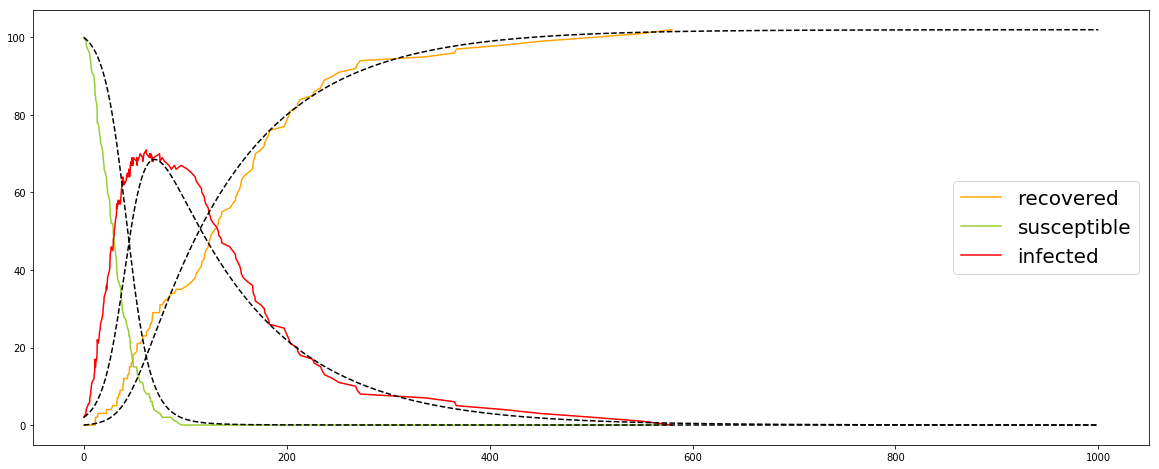

In [8]:
plt.figure(figsize = (20,8))
plt.plot(t, r,c='orange', label = 'recovered')
plt.plot(t,s, c='yellowgreen',label = 'susceptible')
plt.plot(t,i,c= 'r', label = 'infected')
plt.legend(fontsize = 20)

plt.plot(ts, P_sir[:,2],'--', c='k', label = 'recovered')
plt.plot(ts,P_sir[:,0],'--', c='k',label = 'susceptible')
plt.plot(ts,P_sir[:,1],'--',c= 'k', label = 'infected')


# SEIR
$ \frac{dS}{dt} = - \beta \frac{SI}{N} \\
\frac{dE}{dt} = \beta \frac{SI}{N} - \sigma E \\
 \frac{dI}{dt} = \sigma E - \mu I \\
 \frac{dR}{dt} = \mu I $

In [7]:
def gillespieSEIR(initial, beta, mu, sigma, max_time):
    T = []
    pop = []
    N = sum(initial)
    pop.append(initial)
    T.append(0)
    t = 0
    ind = 0
    while t <max_time and (pop[ind][2]+pop[ind][1])>0:
        state = np.zeros(shape= (4,3))
        R1 = beta*(pop[ind][0])*(pop[ind][2])/N #S>E
        state[:,0] = [-1, 1, 0, 0]
        R2 = sigma*pop[ind][1]
        state[:,1] = [0, -1, 1, 0]
        R3 = mu*(pop[ind][2])
        state[:,2] = [0, 0, -1, 1]
        rate = [R1, R2, R3]
        Rtotal = sum(rate)
        delta_t= -np.log(np.random.uniform(0,1))/Rtotal

        P = np.random.uniform(0,1)*Rtotal
        t =t+ delta_t
        event = np.min(np.where(P<=np.cumsum(rate)))
        T.append(t)
        pop.append(pop[ind]+state[:,event])

        ind=ind+1
    return T, np.array(pop)

In [8]:
Input = [100,0,2,0]
G1 = gillespieSEIR(Input, β, μ, σ, T)
t = G1[0]
s = G1[1][:,0]
e = G1[1][:,1]
i = G1[1][:,2]
r = G1[1][:,3]

In [9]:
def dSEIR_dt(X, t):
    return [-β*X[0]*X[2]/N, β*X[0]*X[2]/N - σ*X[1], σ*X[1] - μ*X[2], μ*X[2]]

ts = np.linspace(0, T, 1000)
N = sum(Input)
P_seir = odeint(dSEIR_dt, Input, ts)



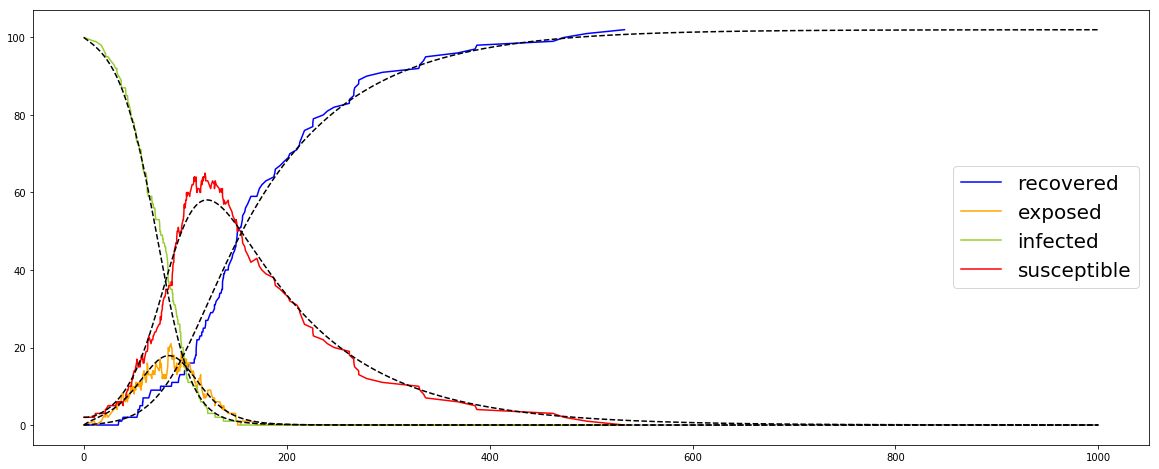

In [10]:
plt.figure(figsize = (20,8))
plt.plot(t, r,c='blue', label = 'recovered')
plt.plot(t, e,c='orange', label = 'exposed')

plt.plot(t,s, c='yellowgreen',label = 'infected')
plt.plot(t,i,c= 'r', label = 'susceptible')
plt.legend(fontsize = 20)

plt.plot(ts, P_seir[:,3],'--', c='k', label = 'recovered')
plt.plot(ts,P_seir[:,0],'--', c='k',label = 'susceptible')
plt.plot(ts,P_seir[:,1],'--',c= 'k', label = 'exposed')
plt.plot(ts,P_seir[:,2],'--',c= 'k', label = 'infected')

# SEIHR
$ \frac{dS}{dt} = - \beta \frac{S(I + \alpha H)}{N} - \varepsilon S \\
\frac{dE}{dt} = \beta \frac{S(I + \alpha H)}{N} + \varepsilon S - \sigma E \\
 \frac{dI}{dt} = \sigma E - (\mu + \omega) I \\
 \frac{dH}{dt} = \omega I - \mu H \\
 \frac{dR}{dt} = \mu( I + H )$

In [11]:
def gillespieSEIHR(initial, beta, mu1,mu2, sigma, omega,epsilon,alpha,  max_time):
    event_time = []
    pop = []
    N = sum(initial)
    pop.append(initial)
    event_time.append(0)
    times = 0
    ind = 0
    cuminf = []
    cuminf.append(0)
    events = []
    while times <max_time:
        state = np.zeros(shape= (5,5))
        R1 = beta*(pop[ind][0])*(pop[ind][2] + alpha*pop[ind][3])/N + epsilon*pop[ind][0] 
#         print(alpha)
        state[:,0] = [-1, 1, 0, 0,0]
        R2 = sigma*pop[ind][1]
        state[:,1] = [0, -1, 1, 0,0]
        R3 = omega*pop[ind][2]
        state[:,2] = [0, 0, -1, 1, 0]
        R4 = mu1*pop[ind][2]
        state[:,3] = [0,0,-1,0,1]
        R5 = mu2*pop[ind][3]
        state[:,4] = [0,0,0,-1,1]
        rate = [R1, R2, R3, R4, R5]
        Rtotal = sum(rate)
        delta_t= -np.log(np.random.uniform(0,1))/Rtotal
#         print('det', delta_t)
        P = np.random.uniform(0,1)*Rtotal
        times =times+ delta_t
        event = np.min(np.where(P<=np.cumsum(rate)))
        events.append(event)
        event_time.append(times)
        pop.append(pop[ind]+state[:,event])
        if event == 1:
            cuminf.append(1 )
        else:
            cuminf.append(0)
        ind=ind+1
#         print(event_time)
    return event_time, np.array(pop), events

In [17]:
β = 0.2
μ1 = 1/19 #14 days infectious
μ2 = 1/5 #5 days (14 - 9 days)
σ =1/5 #5 days exposed
ω=1/9 # 9 days until emitted to hospital
ϵ = 0.0001
α = 1

capT = 200
Input_H = [1502,0,0,0,0]


In [18]:
def dSEIHR_dt(X, tt ):
    return [-β*X[0]*(X[2]+α*X[3])/Nn - ϵ*X[0], β*X[0]*(X[2]+α*X[3])/Nn + ϵ*X[0]- σ*X[1], σ*X[1] - (μ1+ω)*X[2], ω*X[2]-μ2*X[3], μ1*X[2]+μ2*X[3]]

ts = np.linspace(0, capT, 1000)
Nn = sum(Input_H)
P_seihr = odeint(dSEIHR_dt, Input_H, ts)


In [22]:
Gh = gillespieSEIHR(Input_H, β, μ1, μ2, σ, ω, ϵ, α, capT)
SEIHRt = Gh[0]
SEIHRs = Gh[1][:,0]
SEIHRe = Gh[1][:,1]
SEIHRi = Gh[1][:,2]
SEIHRh = Gh[1][:,3]
SEIHRr = Gh[1][:,4]

(0, 200)

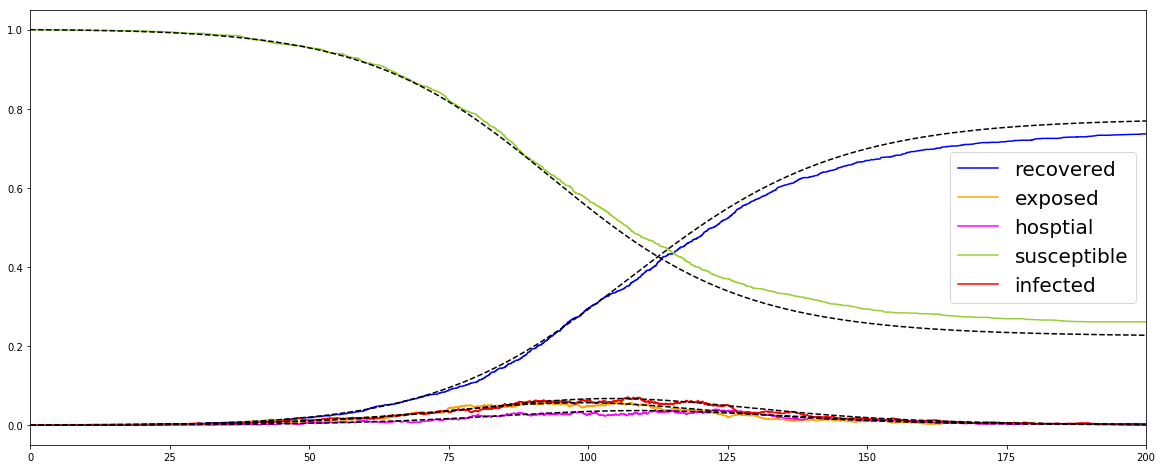

In [24]:
plt.figure(figsize = (20,8))
plt.plot(SEIHRt, SEIHRr/Nn,c='blue', label = 'recovered')
plt.plot(SEIHRt, SEIHRe/Nn,c='orange', label = 'exposed')
plt.plot(SEIHRt, SEIHRh/Nn,c='magenta', label = 'hosptial')

plt.plot(SEIHRt,SEIHRs/Nn, c='yellowgreen',label = 'susceptible')
plt.plot(SEIHRt,SEIHRi/Nn,c= 'r', label = 'infected')
plt.legend(fontsize = 20)

plt.plot(ts, P_seihr[:,3]/Nn,'--', c='k', label = 'hospital')
plt.plot(ts, P_seihr[:,4]/Nn,'--', c='k', label = 'recovered')
plt.plot(ts,P_seihr[:,0]/Nn,'--', c='k',label = 'susceptible')
plt.plot(ts,P_seihr[:,1]/Nn,'--',c= 'k', label = 'exposed')
plt.plot(ts,P_seihr[:,2]/Nn,'--',c= 'k', label = 'infected')
plt.xlim([0,capT])